In [1]:
import emip_toolkit as EMTK
from IPython.display import Image
import correction
import random 
import numpy as np
import PIL
from matplotlib import pyplot as plt

In [2]:
img = Image(filename= r'C:\Users\PC\Desktop\NN_with_Transfer_Learning\synthetic_text.png')
# img

In [3]:
image_path =''
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")
aoi.head()

,kind,name,x,y,width,height,image
0,sub-line,line 1 part 1,137.5,147,119,44,synthetic_text.png
1,sub-line,line 1 part 2,262.5,147,114,44,synthetic_text.png
2,sub-line,line 1 part 3,382.5,147,65,44,synthetic_text.png
3,sub-line,line 1 part 4,453.5,147,57,44,synthetic_text.png
4,sub-line,line 1 part 5,514.5,147,72,44,synthetic_text.png


In [4]:
file_path = ''
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()

,kind,name,x,y,width,height,image,token
0,sub-line,line 1 part 1,137.5,147,119,44,synthetic_text.png,Margie
1,sub-line,line 1 part 2,262.5,147,114,44,synthetic_text.png,moved
2,sub-line,line 1 part 3,382.5,147,65,44,synthetic_text.png,into
3,sub-line,line 1 part 4,453.5,147,57,44,synthetic_text.png,her
4,sub-line,line 1 part 5,514.5,147,72,44,synthetic_text.png,new


In [5]:
line_ys = correction.find_lines_Y(aois_with_tokens)

In [6]:
x = 584
y = 1216
n = 20

input_x = x//2
input_y = y//2
num_train = 5*11*n

x_train = np.zeros((num_train, input_x, input_y, 3), dtype=np.uint8)
y_train = np.zeros(num_train, dtype=int)

error_types = [0, 1, 2, 3, 4]

In [7]:
def make_error_trial (error_type, factor):
    synth_fixations = correction.generate_fixations_lr_skip_regression(aois_with_tokens)
        
    if error_type == 0: # noise
        error_trial = correction.error_noise(factor/10.0, random.randint(0, 50), factor/10.0, synth_fixations) 
    elif error_type == 1: # shift
        line_ys = np.array(synth_fixations)[:, 1]
        error_trial = correction.error_shift(factor/10.0, line_ys, synth_fixations) 

    elif error_type == 2: # droop
        error_trial = correction.error_droop(factor, synth_fixations)  
    
    elif error_type == 3: # offset 
        error_trial = correction.error_offset(factor*2.0, factor*2.0, synth_fixations)
    elif error_type == 4: # no error
        error_trial = synth_fixations  

    else: # wrong entry
        print("Error: wrong entry; there is no error category")
        return
    return error_trial

In [8]:
prev = 0

for i in range(len(error_types)): 
    for j in range(0, 11): 
        for index in range(n):
          w = i*11*n + j*n + index
          
          # double check the index in x_train is correct
          if w < prev:
            print(i, j, index, w, prev)
            exit()
          else:
            prev = w
            
          error_trial = make_error_trial(error_types[i], j+index*1/n)
          if j == 0 and index < 2:
           y_train[w] = 4
          else:
           y_train[w] = error_types[i]

          im = correction.fix_to_img('synthetic_text.png', error_trial)
          im_small = im.resize((input_y, input_x)) # shrink image to fit in model, shape defined in prev cell
          im_small_array = np.asarray(im_small)

          x_train[w] = im_small_array

          # plt.imshow(x_train[index])


np.save("data/x_train_mix.npy", x_train)
np.save("data/y_train_mix.npy",y_train)

2


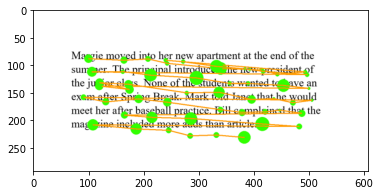

In [14]:
# x_train.shape
a = -500
plt.imshow(x_train[a])
print(y_train[a])

In [8]:
n_test = 500

x_test = np.zeros((n_test, input_x, input_y, 3), dtype=np.uint8)
y_test = np.zeros(n_test, dtype=int)

In [9]:
for i in range(n_test):
    error = random.choice(error_types)
    factor = random.randint(0, 10)
    error_trial = make_error_trial(error, factor)
    
    if factor <= 1:
        y_test[i] = 4
    else:
        y_test[i] = error

    im = correction.fix_to_img('synthetic_text.png', error_trial)
    im_small = im.resize((input_y, input_x))
    im_small_array = np.asarray(im_small)
    x_test[i] = im_small_array

np.save("data/x_test_mix.npy", x_test)
np.save("data/y_test_mix.npy", y_test)